In [24]:
!pip install pandas pillow matplotlib sklearn torch torchvision albumentations -q

!pip install git+https://github.com/qubvel/segmentation_models.pytorch -q
    
!pip install catalyst -q

import cv2

import albumentations as albu
import albumentations.pytorch as AT

from catalyst.dl.runner import SupervisedRunner
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback

import segmentation_models_pytorch as smp

import torch
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

from sklearn.model_selection import train_test_split

%matplotlib inline

In [25]:
raw = pd.read_csv('../data/train.csv')

data = raw.copy()

raw.head()

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

## Dataset analysis

In [26]:
data.loc[:, 'id'] = data.loc[:, 'Image_Label'].apply(lambda x: x.split('_')[0])
data.loc[:, 'label'] = data.loc[:, 'Image_Label'].apply(lambda x: x.split('_')[1])

data.loc[data.loc[:, 'EncodedPixels'].isnull(), 'label'] = np.nan

data.set_index('id', drop=True, inplace=True)

data.head(5)

Image_Label  \
id                                
0011165.jpg    0011165.jpg_Fish   
0011165.jpg  0011165.jpg_Flower   
0011165.jpg  0011165.jpg_Gravel   
0011165.jpg   0011165.jpg_Sugar   
002be4f.jpg    002be4f.jpg_Fish   

                                                 EncodedPixels   label  
id                                                                      
0011165.jpg  264918 937 266318 937 267718 937 269118 937 27...    Fish  
0011165.jpg  1355565 1002 1356965 1002 1358365 1002 1359765...  Flower  
0011165.jpg                                                NaN     NaN  
0011165.jpg                                                NaN     NaN  
002be4f.jpg  233813 878 235213 878 236613 878 238010 881 23...    Fish

In [27]:
#  number of labels in each image
data.groupby('id').count().sort_values('label')

Image_Label  EncodedPixels  label
id                                            
ffea4f4.jpg            4              1      1
33a5c0d.jpg            4              1      1
338b26d.jpg            4              1      1
c6b1b36.jpg            4              1      1
5e502b0.jpg            4              1      1
...                  ...            ...    ...
d2eb9fe.jpg            4              4      4
baee301.jpg            4              4      4
3d5a458.jpg            4              4      4
3c890ca.jpg            4              4      4
09a95c4.jpg            4              4      4

[5546 rows x 3 columns]

In [28]:
#  number of images that have a number of labels
data.groupby('id').count().sort_values('label').groupby('label').count()

Image_Label  EncodedPixels
label                            
1             1348           1348
2             2372           2372
3             1560           1560
4              266            266

##  Masking images

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def rle_decode(mask_rle, shape):
    " https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools "
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [30]:
images = list(set(data.index))

['f15d534.jpg' 'fc93558.jpg' 'd1820b5.jpg' '79648fa.jpg']


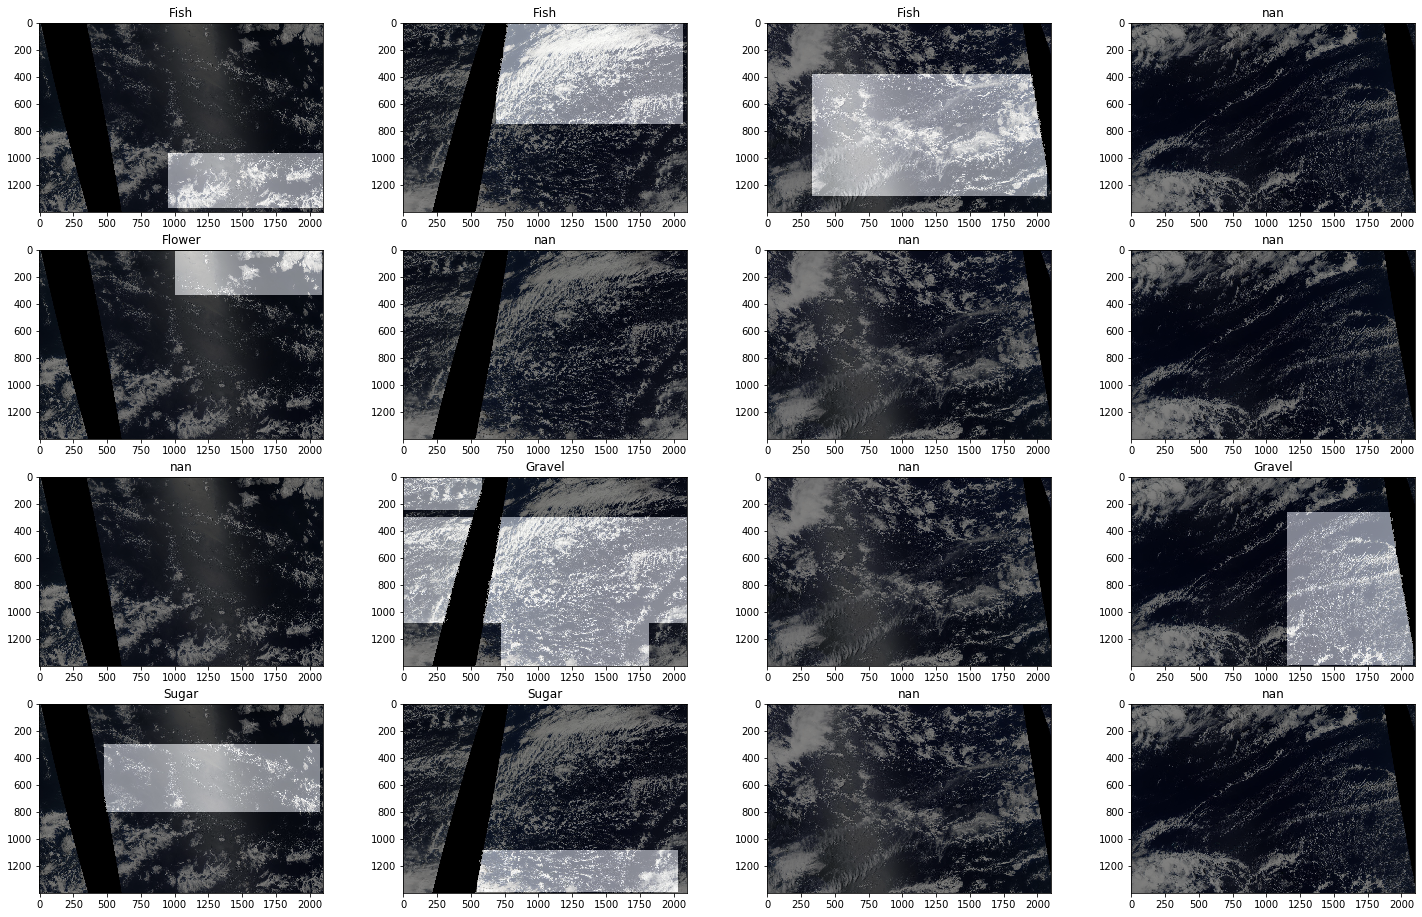

In [31]:
def plot_images():
    nrows = 4
    sample = np.random.choice(images, nrows)
    print(sample)

    shape = (1400, 2100)

    f, axes = plt.subplots(nrows, 4, figsize=(25, 16))

    for idx, img_id in enumerate(sample):
        sub = data.loc[data.index == img_id]

        img = Image.open('../data/train-images/{}'.format(img_id))

        for col, ax in enumerate(axes[:, idx]):
            ax.imshow(img)
            ax.set_title(sub.loc[:, 'label'].iloc[col])

            try:
                mask = rle_decode(sub.loc[:, 'EncodedPixels'].iloc[col], shape)

            except AttributeError:
                mask = np.zeros(shape)

            ax.imshow(mask, alpha=0.5 , cmap='gray')
            
plot_images()

['bdd2fe5.jpg' '32f591b.jpg' '0b6e69c.jpg' '0a99863.jpg']


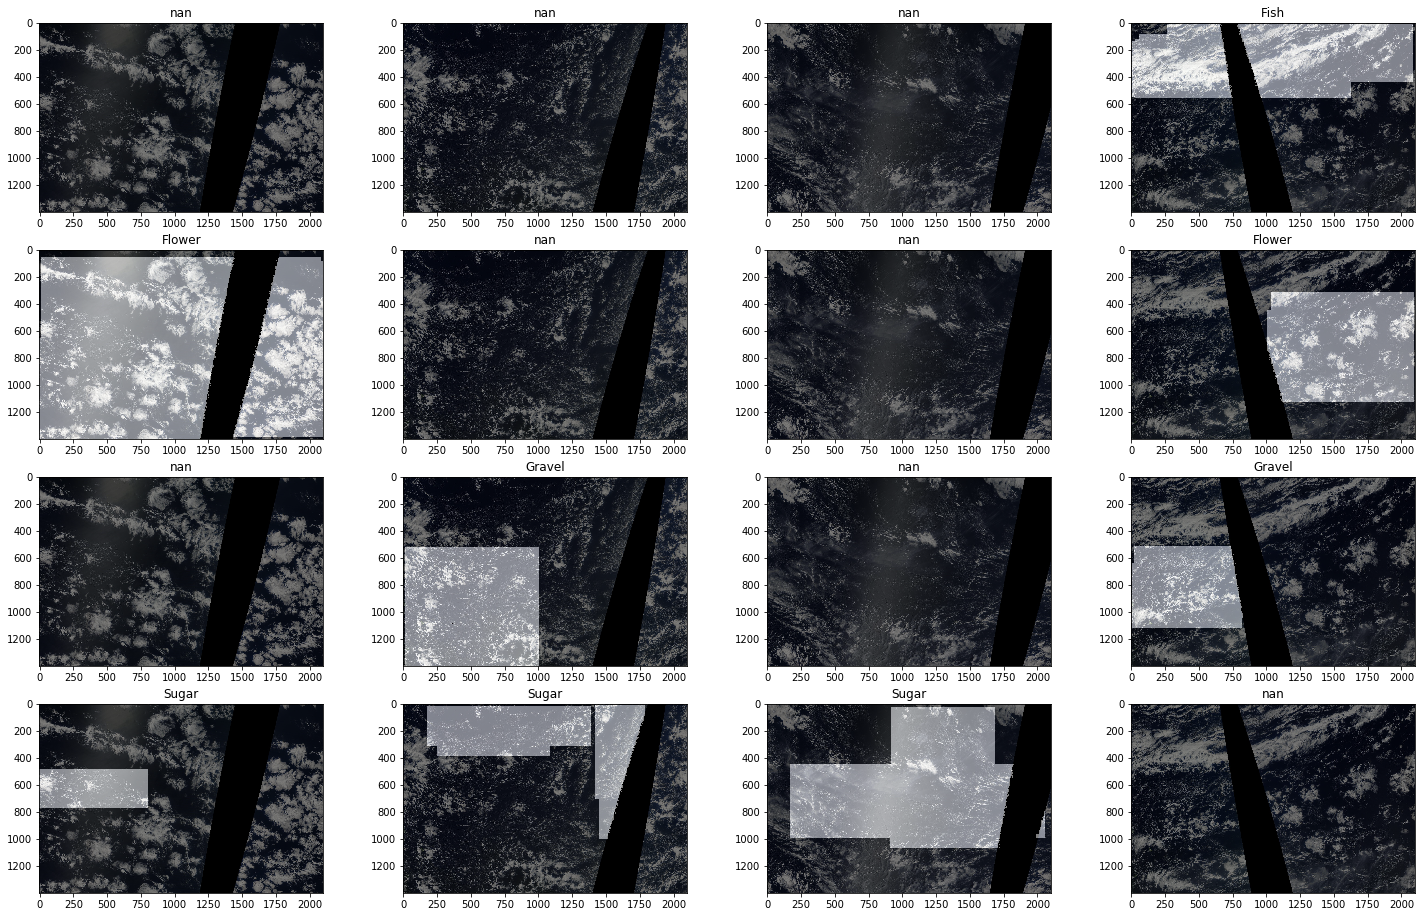

In [32]:
plot_images()

In [33]:
data

Image_Label  \
id                                
0011165.jpg    0011165.jpg_Fish   
0011165.jpg  0011165.jpg_Flower   
0011165.jpg  0011165.jpg_Gravel   
0011165.jpg   0011165.jpg_Sugar   
002be4f.jpg    002be4f.jpg_Fish   
...                         ...   
ffd6680.jpg   ffd6680.jpg_Sugar   
ffea4f4.jpg    ffea4f4.jpg_Fish   
ffea4f4.jpg  ffea4f4.jpg_Flower   
ffea4f4.jpg  ffea4f4.jpg_Gravel   
ffea4f4.jpg   ffea4f4.jpg_Sugar   

                                                 EncodedPixels   label  
id                                                                      
0011165.jpg  264918 937 266318 937 267718 937 269118 937 27...    Fish  
0011165.jpg  1355565 1002 1356965 1002 1358365 1002 1359765...  Flower  
0011165.jpg                                                NaN     NaN  
0011165.jpg                                                NaN     NaN  
002be4f.jpg  233813 878 235213 878 236613 878 238010 881 23...    Fish  
...                                                        ...     ...  
ffd6680.jpg                                                NaN     NaN  
ffea4f4.jpg                                                NaN     NaN  
ffea4f4.jpg  1194860 675 1196260 675 1197660 675 1199060 67...  Flower  
ffea4f4.jpg                                                NaN     NaN  
ffea4f4.jpg                                                NaN     NaN  

[22184 rows x 3 columns]

In [34]:
id_grp = data.groupby(data.index).count()

sub = id_grp.iloc[:50, :]

In [35]:
train_id, valid_id = train_test_split(sub.index, test_size=0.2, stratify=sub.loc[:, 'label'])

print(train_id.shape, valid_id.shape)

(40,) (10,)


## Augmentations

- flips (horiz, vertical)
- rotations
- elastic transform (blurring edges of the mask)
- grid distortion
- optical distortion

In [36]:
from torch.utils.data import TensorDataset, DataLoader, Dataset

## Torch dataset

In [37]:
def make_all_masks(data, img_id, shape=(1400, 2100)):
    label_order = ['Fish', 'Flower', 'Gravel', 'Sugar']
    
    mask_data = data.loc[data.index == img_id, :]
    masks = np.zeros((*shape, len(label_order)))

    for idx, expected_label in enumerate(label_order):
        d = mask_data.iloc[idx]
        lbl = d.loc['label']

        if lbl is not np.nan:
            assert lbl == expected_label
            masks[:, :, idx] = rle_decode(d.loc['EncodedPixels'], shape)
    return masks

In [38]:
class CloudDataset(Dataset):
    
    def __init__(
        self,
        data,
        dataset='train',
        transform=albu.Compose([albu.HorizontalFlip(), AT.ToTensor()]),
        preprocessing=None
    ):
        super().__init__()
        self.data = data
        self.folder = os.path.join('../data/train-images')
        self.transform = transform
        self.preprocessing = preprocessing
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        img_data = self.data.iloc[idx, :]
        img_id = img_data.name
        
        mask = make_all_masks(self.data, img_id)
        
        img = cv2.imread(os.path.join(self.folder, img_id))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        augmented = self.transform(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
            
        return img, mask
    
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Resize(320, 640)
    ]
    return albu.Compose(train_transform)

def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [39]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'
ACTIVATION = None

bs = 16
num_workers = 0

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4,   #  5 - no class????
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

train_dataset = CloudDataset(
    data.loc[train_id, :], 
    dataset='train', 
    transform=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = CloudDataset(
    data.loc[valid_id, :], 
    dataset='train', 
    transform=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

loaders = {
    'train': DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers),
    'valid': DataLoader(valid_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
}

/Users/adam/.pyenv/versions/3.6.8/envs/clouds/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2875: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [40]:
data.loc[train_id, :]

Image_Label  \
id                                
015aa06.jpg    015aa06.jpg_Fish   
015aa06.jpg  015aa06.jpg_Flower   
015aa06.jpg  015aa06.jpg_Gravel   
015aa06.jpg   015aa06.jpg_Sugar   
00d4443.jpg    00d4443.jpg_Fish   
...                         ...   
0277e9a.jpg   0277e9a.jpg_Sugar   
022a275.jpg    022a275.jpg_Fish   
022a275.jpg  022a275.jpg_Flower   
022a275.jpg  022a275.jpg_Gravel   
022a275.jpg   022a275.jpg_Sugar   

                                                 EncodedPixels   label  
id                                                                      
015aa06.jpg  1589785 293 1591185 293 1592585 293 1593985 29...    Fish  
015aa06.jpg  1230602 1081 1232002 1081 1233402 1081 1234802...  Flower  
015aa06.jpg  43851 252 44105 40 45251 269 45521 2 45525 1 4...  Gravel  
015aa06.jpg  2846 517 3364 2 3367 5 3401 3 4246 509 4756 1 ...   Sugar  
00d4443.jpg                                                NaN     NaN  
...                                                        ...     ...  
0277e9a.jpg  2338938 462 2340338 462 2341738 462 2343138 46...   Sugar  
022a275.jpg                                                NaN     NaN  
022a275.jpg                                                NaN     NaN  
022a275.jpg  37932 793 39332 793 40732 793 42132 793 43532 ...  Gravel  
022a275.jpg                                                NaN     NaN  

[160 rows x 3 columns]

In [41]:
len(DataLoader(valid_dataset, batch_size=bs, shuffle=True, num_workers=num_workers))

3

In [43]:
num_epochs = 19
logdir = "./logs/segmentation"

# model, criterion, optimizer
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-2}, 
    {'params': model.encoder.parameters(), 'lr': 1e-3},  
])
scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
criterion = smp.utils.losses.BCEDiceLoss(eps=1.)
runner = SupervisedRunner()

In [ ]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[DiceCallback(), EarlyStoppingCallback(patience=5, min_delta=0.001)],
    logdir=logdir,
    num_epochs=1,
    verbose=True
)

<IPython.core.display.Javascript object>

0/1 * Epoch (train):  30% 3/10 [05:16<12:19, 105.66s/it, _timers/_fps=0.399, dice=0.261, loss=1.475]